#### CMSE 202 Final Project
### &#9989; Ky Nguyen

# 1 - Project: Creating Clothing using GANS
---

## 1.1 - Background and Motivation
Our brains are able to recognize images at a moment's glance and if they are simple enough, we can recreate them right after. For example, a circle. If we're able to draw something simple as that after seeing an example, then a computer should be able to recreate one as well, right? Well, it's a bit difficult to actually prove if that is true. This project, however, serves to prove if that implication is at least plausible.
   
This project involves concepts such as AI and deep learning. The hardest part about this is doing the research and learning about those topics as they are both oblivious to me. Here, we will see how fast and how long we can train our AI to be able to recreate these various clothing from a dataset and try to make sense of the question: **If we humans can draw it, then can a computer draw it as well?**

---
## 1.2 - Methodology
We will be using [**GANS (generative adversarial networks)**](https://arxiv.org/abs/1406.2661) to train two models simultaneously:
- **Generative Model** - Model that generates the images
- **Discriminative Model** - Model that determines whether the images were generated or real images.

In order to train these two models, we will have them compete against each other. The generative model is learning how to create unique clothing using a dataset of clothing and the discriminative model learning how to distinguish whether a sample came from the generative model's distribution or the training data's distribution.

The generative model's purpose is to try to produce and use fake data without detection, while the discriminative model's purpose is to try to detect that fake data. This MiniMax competition between these two models serves to improve their methods in achieving their purpose. In the end, we want to maximize the probability of the discriminator making a mistake so that our generative model can successful produce unique images.

**The training algorithm for the discriminator and generator model is summarized in the figure below:**
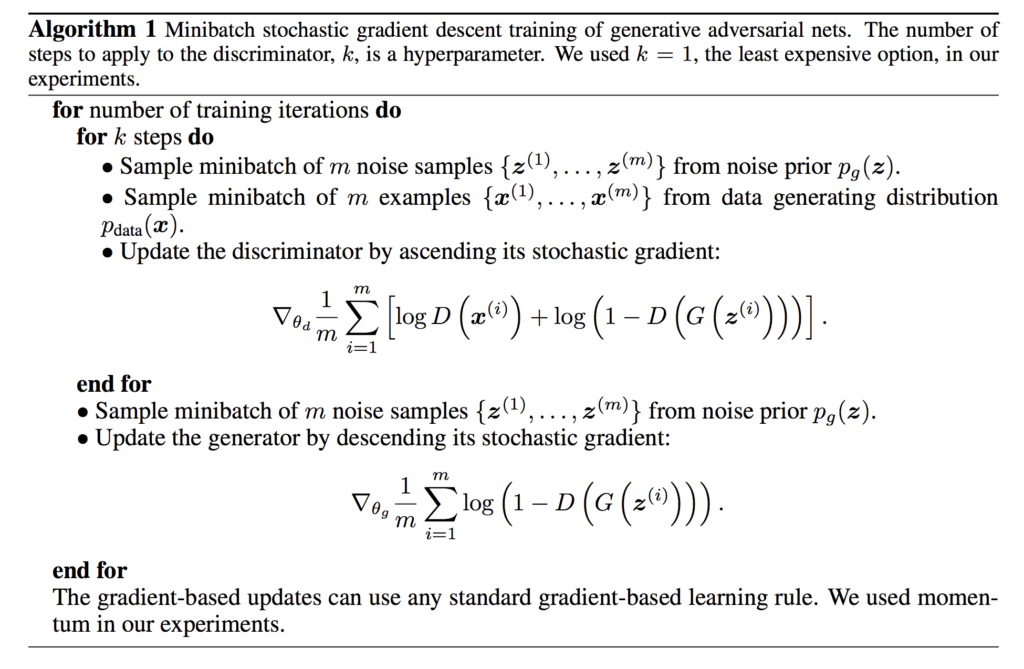

Luckily, the `tensorflow` module that we will be using have functions that will take care of that for us.

### 1.2.1 - Importing our packages
We will be using modules that we have been using in class (`matplotlib` and `numpy`) to plot and manipulate our models. We will also be using a module called `tensorflow`, which will be the backbone of this project. It contains our dataset and various functions to aid us in training our models. Other modules like `time`, `os`, `glob`, and `imageio` will be used to display our GANS output.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
import tensorflow as tf
import time
import os
import glob
import imageio
from IPython import display
from ipywidgets import interact

%matplotlib inline

### 1.2.2 - Loading our Fashion dataset
`Tensorflow` contains a dataset called `fashion_mnist` which contains images of 60000 different clothing pieces. Since this is an unsupervised machine learning model, we completely discard the training labels and only use the images of the dataset.

In [2]:
# Loading dataset from tensorflow
fashion_mnist = tf.keras.datasets.fashion_mnist

# Splitting original dataset and only using train_images
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Categories of clothing
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Testing if we correctly loaded our datasets and seeing what kind of data we are working with:**

In [3]:
# Initialize figure
def browse_images(images, labels, categories):
    """Create an interactive view of our images"""
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(train_images, train_labels, class_names)

interactive(children=(IntSlider(value=29999, description='i', max=59999), Output()), _dom_classes=('widget-int…

### 1.2.3 - Preprocess and prepare data

Our dataset right now is very messy and makes it difficult for a convulsional neural network to work with. We need to manipulate our data so that it will be workable for our training simulations.

We need to reshape our data then normalize it. Finally we will batch our dataset and store it in a variable called `train_set`.

In [4]:
# Constants
PIXEL_VALUE = 256
IMAGE_SIZE = 28

# Create a buffer equivalent to the datset site
buffer_size = train_images.shape[0]

# We are using the dataset in batches of 256
batch_size = 256

# Reshape the dataset's size into a workable size and cast as float32
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - (PIXEL_VALUE / 2.0)) / (PIXEL_VALUE / 2.0)

# Batch and shuffle the dataset to keep from having same images back to back when training
training_set = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

### 1.2.4 - Creating the GANS Model class

We will create a class that represents our GANS models. We need two functions within our class that initializes our Generative and Discriminative models

In [5]:
class GANS:
    """
    Class that represents our GANS model
    ------------------------------------
    generator - The generative model
    discriminator - The discriminative model
    """
    
    def __init__(self):
        """Start with a tensorflow sequential model"""
        self.generator = tf.keras.Sequential()
        self.discriminator = tf.keras.Sequential()
        
    def init_generator(self, n_nodes, weights, pixels):
        """Initialize a generative model"""
        
        self.generator.add(tf.keras.layers.Dense(n_nodes * weights * pixels, use_bias=False, input_shape=(100,)))
    
        # Use Batch Normalization to normalize inputs and prevent data from blowing up
        self.generator.add(tf.keras.layers.BatchNormalization())

        # Use Leaky Rectified Linear unit as activation function
        # We are using Leaky ReLU because it performs better than other activation functions
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Reshape the layers
        self.generator.add(tf.keras.layers.Reshape((n_nodes, weights, pixels)))

        # Downscale into half (256 -> 128)
        self.generator.add(tf.keras.layers.Conv2DTranspose(pixels / 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Downscale into half (128 -> 64)
        self.model.add(tf.keras.layers.Conv2DTranspose(pixels / 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.LeakyReLU())

        # Finally have 1 as output
        # Use tanH instead of sigmoid as activation since we normalized data to -1 to 1
        self.model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        
    def init_discriminator(self, pixels, image_size, frequency=0.3):
        """Initialize a discriminative model"""
        
        # Input shape represents 28 pixels by 28 pixels for one image
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 4, (5, 5), strides=(2, 2), padding='same', input_shape=[image_size, image_size, 1]))

        # Use Leaky Rectified Linear unit as activation function
        self.discriminator.add(tf.keras.layers.LeakyReLU())

        # The Dropout layer randomly sets input units to 0 with a frequency of 30%
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Discriminator works upwards so it upscales network (64 -> 128)
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 2, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Finally add the flat and dense layer
        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1))

### 1.2.5 - The Loss Function

We need a Loss Function that reflects the distance between the distribution of the data generated by the GAN and the distribution of real data. That measurement is called the **cross-entropy**. In our MiniMax competition, the discriminator wants to minimize the cross-entropy, but the generator wants to maximize that same cross-entropy. Hence, we will be using a **Cross-Entropy** loss function for our 2 models.

More specifically, we'll be using a **Binary Cross-Entropy** loss function. This is like the cross-entropy loss function, but it uses binary values for classification:
- 0, generated image
- 1, real image

**The Binary Cross-Entropy can be given from this equation:**
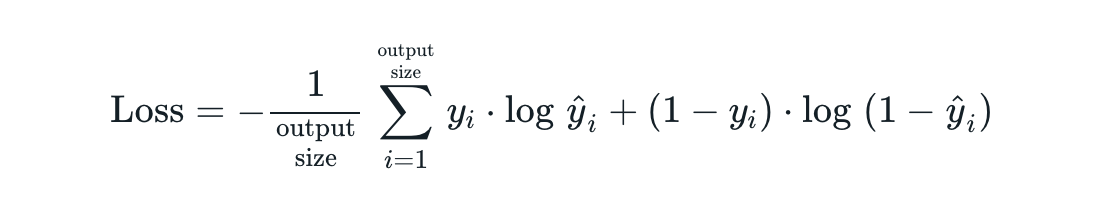
- **$y_{i}$**, is the predicted probability of the discriminator

Looks complicated, but `tensorflow` contains a function that computes this for us!

In [8]:
# Acts as a function to return the BinaryCrossEntropy
bin_cross_entropy_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Using our loss function, we can compute the generator and discriminator loss.**

We'll edit our GANS class to take account of the Loss Function. We will create two helper functions in our class, `compute_generator_loss` and `compute_discriminator_loss` to calculate the generator and discriminator total loss.

1. `compute_generator_loss` takes 1 argument:
    - **simulated_output** - The simulated/fake images


2. `compute_discriminator_loss` takes 2 arguments:
    - **real_output** - The real/training images
    - **simulated_output** - The simulated/fake images

In [6]:
class GANS:
    """
    Class that represents our GANS model
    ------------------------------------
    generator - The generative model
    discriminator - The discriminative model
    loss_function - The loss function
    """
    
    def __init__(self):
        """Start with a tensorflow sequential model"""
        self.generator = tf.keras.Sequential()
        self.discriminator = tf.keras.Sequential()
        self.loss_function = None
        
    def init_generator(self, n_nodes, weights, pixels):
        """Initialize a generative model"""
        
        self.generator.add(tf.keras.layers.Dense(n_nodes * weights * pixels, use_bias=False, input_shape=(100,)))
    
        # Use Batch Normalization to normalize inputs and prevent data from blowing up
        self.generator.add(tf.keras.layers.BatchNormalization())

        # Use Leaky Rectified Linear unit as activation function
        # We are using Leaky ReLU because it performs better than other activation functions
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Reshape the layers
        self.generator.add(tf.keras.layers.Reshape((n_nodes, weights, pixels)))

        # Downscale into half (256 -> 128)
        self.generator.add(tf.keras.layers.Conv2DTranspose(pixels / 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Downscale into half (128 -> 64)
        self.generator.add(tf.keras.layers.Conv2DTranspose(pixels / 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Finally have 1 as output
        # Use tanH instead of sigmoid as activation since we normalized data to -1 to 1
        self.generator.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        
    def init_discriminator(self, pixels, image_size, frequency):
        """Initialize a discriminative model"""
        
        # Input shape represents 28 pixels by 28 pixels for one image
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 4, (5, 5), strides=(2, 2), padding='same', input_shape=[image_size, image_size, 1]))

        # Use Leaky Rectified Linear unit as activation function
        self.discriminator.add(tf.keras.layers.LeakyReLU())

        # The Dropout layer randomly sets input units to 0 with a frequency
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Discriminator works upwards so it upscales network (64 -> 128)
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 2, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Finally add the flat and dense layer
        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1))
        
    def set_loss_function(self, func):
        """Set the loss function for our GANS model"""
        self.loss_function = func
        
    def _compute_generator_loss(self, simulated_output):
        """Calculates and returns the Generator loss"""
        return self.loss_function(tf.ones_like(simulated_output), simulated_output)
    
    def _compute_discriminator_loss(self, real_output, simulated_output):
        """Calculates and returns the Discriminator loss"""
        # How much was lost from the actual images?
        # Using "tf.ones_like" creates a tensor of all ones that has the same shape as the input.
        real_loss = self.loss_function(tf.ones_like(real_output), real_output) 

        # How much was lost from the simulated/fake images?
        # Using "tf.zeros_like" creates a tensor of all that dont have the same shape as the input.
        simulated_loss = self.loss_function(tf.zeros_like(simulated_output), simulated_output)

        # Return the sum of both individual losses
        return real_loss + simulated_loss

### 1.2.6 - Seeing what our generator produces without training

Using the class we created, lets initialize a testing GANS model to see what we can generate.

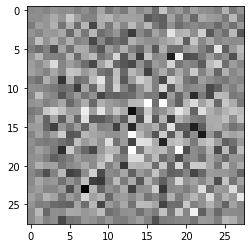

In [9]:
n_nodes = 7
weights = 7
freq = 0.3

model = GANS()
model.init_generator(n_nodes, weights, PIXEL_VALUE)
model.init_discriminator(PIXEL_VALUE, IMAGE_SIZE, freq)
model.set_loss_function(bin_cross_entropy_func)

gen_noise = tf.random.normal([1, 100])
gen_img = model.generator(gen_noise)
plt.imshow(gen_img[0, :, :, 0], cmap='gray')
plt.show()

### 1.2.7 - Creating the model optimizers

We need an optimization algorithm so we can efficiently train our two models. There are many types of optimization algorithms out there and `tensorflow` have built-in optimizers for us to use.

**Gradient descent** is optimization algorithm that commonly is preferred in optimizing neural networks and many other machine learning algorithms. We will be using [**Adam**](https://arxiv.org/abs/1412.6980) optimizer, which is an extension and improvement of gradient descent. This will allow our 2 models to efficiently optimize their gradient descent.

Below we will rewrite our GANS model class to implement optimizers. For now, lets set our learning rate.

In [10]:
# How much to change the model
learning_rate = 1e-4

### 1.2.8 - Training our models

#### 1. Initializing the training parameters:

In [11]:
# How long to train for
epochs = 100 # Amount of complete passes in the training step

# Dimensionality of the random noise
noise_dim = 100

# Number of samples we want to look at
n_samples = 16

# Seed for our random samples we want to examine
seed = tf.random.normal([n_samples, noise_dim])

#### 2. Implement training to our GANS class:

In [12]:
class GANS:
    """
    Class that represents our GANS model
    ------------------------------------
    generator - The generative model
    discriminator - The discriminative model
    gen_optimizer - The optimizer for the generative model
    dis_optimizer - The optimizer for the generative model
    loss_function - The loss function
    """
    
    def __init__(self, learning_rate):
        """Start with a tensorflow sequential model"""
        self.generator = tf.keras.Sequential()
        self.discriminator = tf.keras.Sequential()
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.dis_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.loss_function = None
        
    def init_generator(self, n_nodes, weights, pixels):
        """Initialize a generative model"""
        
        self.generator.add(tf.keras.layers.Dense(n_nodes * weights * pixels, use_bias=False, input_shape=(100,)))
    
        # Use Batch Normalization to normalize inputs and prevent data from blowing up
        self.generator.add(tf.keras.layers.BatchNormalization())

        # Use Leaky Rectified Linear unit as activation function
        # We are using Leaky ReLU because it performs better than other activation functions
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Reshape the layers
        self.generator.add(tf.keras.layers.Reshape((n_nodes, weights, pixels)))

        # Downscale into half (256 -> 128)
        self.generator.add(tf.keras.layers.Conv2DTranspose(pixels / 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Downscale into half (128 -> 64)
        self.generator.add(tf.keras.layers.Conv2DTranspose(pixels / 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        # Finally have 1 as output
        # Use tanH instead of sigmoid as activation since we normalized data to -1 to 1
        self.generator.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        
    def init_discriminator(self, pixels, image_size, frequency):
        """Initialize a discriminative model"""
        
        # Input shape represents 28 pixels by 28 pixels for one image
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 4, (5, 5), strides=(2, 2), padding='same', input_shape=[image_size, image_size, 1]))

        # Use Leaky Rectified Linear unit as activation function
        self.discriminator.add(tf.keras.layers.LeakyReLU())

        # The Dropout layer randomly sets input units to 0 with a frequency
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Discriminator works upwards so it upscales network (64 -> 128)
        self.discriminator.add(tf.keras.layers.Conv2D(pixels / 2, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(frequency))

        # Finally add the flat and dense layer
        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1))
        
    def set_loss_function(self, func):
        """Set the loss function for our GANS model"""
        self.loss_function = func
        
    def train(self, epochs, batch_size, noise_dim, seed, training_set):
        """Train our Generative and Discriminative models"""
        
        def plot_and_save_output(model, epoch, samples):
            """Plot our GANS output and save the image"""
            # Get our generated images
            output = model(samples, training=False)

            # Plot the generated images
            fig = plt.figure(figsize=(8, 8))
            for i in range(output.shape[0]):
                plt.subplot(4, 4, i + 1)
                plt.imshow(output[i, :, :, 0] * (PIXEL_VALUE / 2.0) + (PIXEL_VALUE / 2.0), cmap='gray')
                plt.axis('off')

            # Save the generated images
            plt.savefig(f'training_outputs/image_at_epoch_{epoch}.png')

            # Show plot
            plt.show()
            
        # Start time of training
        start_time = time.time()

        # Training models
        for ep in range(epochs):
            # For each batch in the epoch, do the step of training
            for batch in training_set:
                self._train_iter(batch, batch_size, noise_dim)

            # Plot images and save them
            display.clear_output(wait=True)
            plot_and_save_output(self.generator, ep + 1, seed)

            # Sanity check for if everything is working:
            # Print completed 5 epochs at time
            print(f'Epoch {ep + 1} completed at {time.time() - start_time} seconds')

        # Stop time of training
        stop_time = time.time()

        # Plot final images and save them
        display.clear_output(wait=True)
        plot_and_save_output(self.generator, epochs, seed)

        # Print time stats
        print("Time elapsed:", stop_time - start_time, "seconds")
        print("Epochs:", epochs)
        print("Time/Epoch:", (stop_time - start_time) / epochs, "seconds")
        
    def _train_iter(self, images, batch_size, noise_dim):
        """Processes an iteration of training"""
        # Start with random nosie
        gen_noise = tf.random.normal([batch_size, noise_dim])

        # "tf.GradientTape" records operations for automatic differentiation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Send generated random noise into generator
            gen_img = self.generator(gen_noise, training=True)

            # Send real image into discriminator
            real_output = self.discriminator(images, training=True)

            # Send simulated image into discriminator
            sim_output = self.discriminator(gen_img, training=True)

            # Check Loss for our models
            gen_loss = self._compute_generator_loss(sim_output)
            disc_loss = self._compute_discriminator_loss(real_output, sim_output)

        # Use Gradient Descent to find tune both model into actually learning
        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Apply optimizers to the Gradients
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.dis_optimizer.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))
        
    def _compute_generator_loss(self, simulated_output):
        """Calculates and returns the Generator loss"""
        return self.loss_function(tf.ones_like(simulated_output), simulated_output)
    
    def _compute_discriminator_loss(self, real_output, simulated_output):
        """Calculates and returns the Discriminator loss"""
        # How much was lost from the actual images?
        # Using "tf.ones_like" creates a tensor of all ones that has the same shape as the input.
        real_loss = self.loss_function(tf.ones_like(real_output), real_output) 

        # How much was lost from the simulated/fake images?
        # Using "tf.zeros_like" creates a tensor of all that dont have the same shape as the input.
        simulated_loss = self.loss_function(tf.zeros_like(simulated_output), simulated_output)

        # Return the sum of both individual losses
        return real_loss + simulated_loss

#### 3. Putting it all together to train our models:

**WARNING**: In order to train these models, you will need a pretty strong computer with a powerful GPU. Training can take a couple hours depending on what GPU you have and how many epochs you train for.

I created an account on [PaperSpace](https://www.paperspace.com/) to train these models. It allowed me to open a VM notebook instance with a powerful GPU **(Nvidia Quadro P5000 - $2000+)** for free to train on. I trained the models at 500 epochs which took a couple hours to finish.

If you choose to run the cell below, I recommend training in at a maximum of 5 epochs. This can still take a few minutes. The results may not be pretty however. The greater the epoch (training period) the better the results.

The code below will be commented just in case.

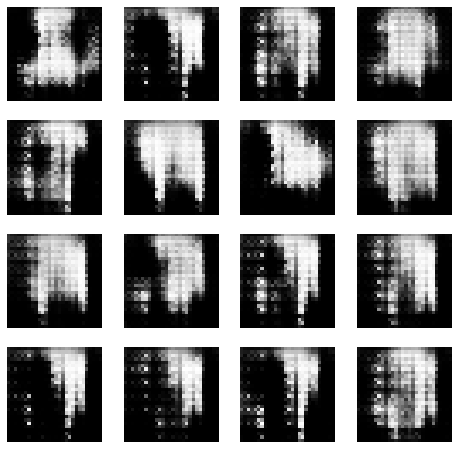

Epoch 4 completed at 853.7017188072205 seconds


In [ ]:
# model = GANS(learning_rate)
# model.init_generator(n_nodes, weights, PIXEL_VALUE)
# model.init_discriminator(PIXEL_VALUE, IMAGE_SIZE, freq)
# model.set_loss_function(bin_cross_entropy_func)

# model.train(epochs, batch_size, noise_dim, seed, training_set)

#### 4. Show generator's evolution:

Using the saved images, we can create a GIF to watch our model's evolution. The following code below will do that.

In [2]:
# with imageio.get_writer('train_evolution.gif', mode='I') as writer:
#     filenames = glob.glob('training_outputs/image*.png')
#     filenames = sorted(filenames, key=lambda name: int(name[38:-4]))
#     for name in filenames:
#         image = imageio.imread(name)
#         writer.append_data(image)
        
# display.Image(open('train_evolution.gif', 'rb').read())

**GANS Output from above code cells:**

1. Epoch = 500, Time Elapsed = 12099.32 seconds

Final Output | Model's Evolution
------------ | ----------------- 
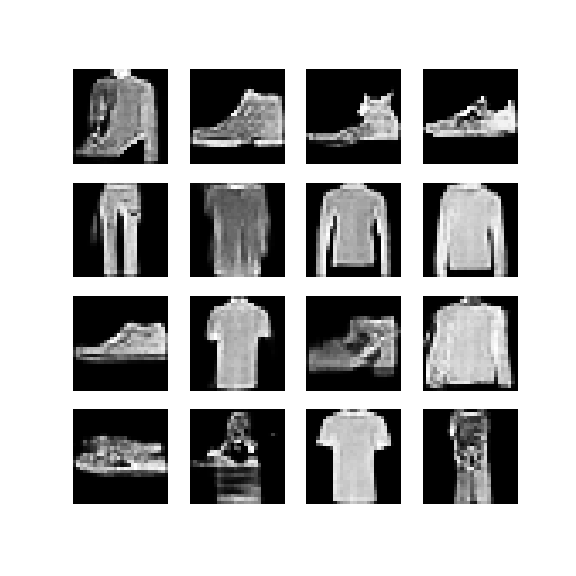 | ![evo_500_1](https://github.com/ky3979/Fashion-GANS/blob/main/results/evolution_500_1.gif?raw=true)

2. Epoch = 500, Time Elapsed = 13342.89 seconds

Final Output | Model's Evolution
------------ | ----------------- 
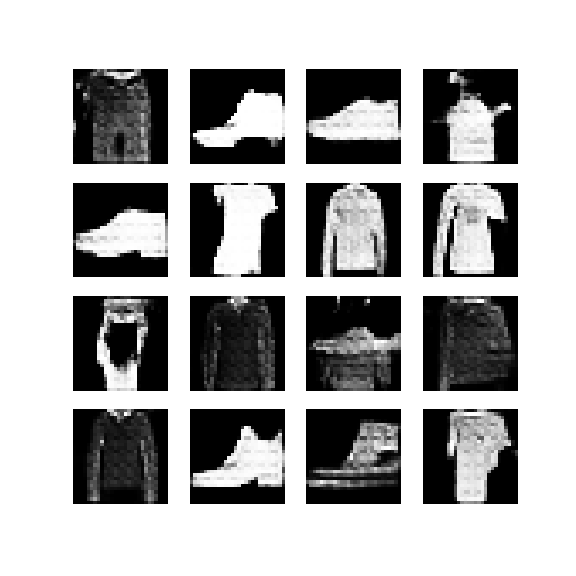 | ![evo_500_2](https://github.com/ky3979/Fashion-GANS/blob/main/results/evolution_500_2.gif?raw=true)

3. Epoch = 742 (Attempt at 1000, but it crashed), Time Elapsed = 122423.34 seconds

Final Output | Model's Evolution
------------ | ----------------- 
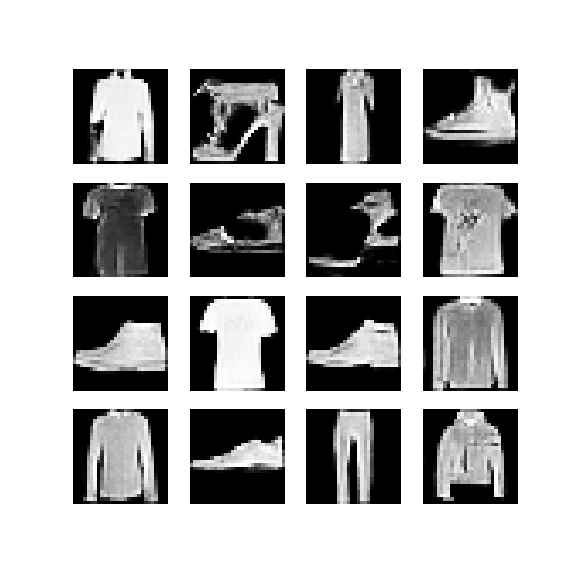 | ![evo_742](https://github.com/ky3979/Fashion-GANS/blob/main/results/evolution_742.gif?raw=true)

---
## 1.3 - Results

### 1.3.1 - Activation Function Understanding

Different activation functions are useful for different situations. In our case, we used the Leaky Relu activation function for most of our layers because it fit the gradient descent the best. In one of our models in the endd, we used the tanh(hyperbolic) activation function for one of our models because we needed a simple activation function which acted similar to a sigmoid to normalize our data from [-1, 1], which was the purpose of the tanh activation function. If we were to use the sigmoid activation function, it would send back normalized data from [0, 1]. 

### 1.3.2 - Output of  the GAN

If we go back to when we created our generator, we could only generate blobs at that point. Given some training, we can see improvements to what our generate could produce. After a few epochs, our blobs have some shape to them. After some ,pre epochs, our shapes are more defined. It's still hard to actually tell what our generator is outputting, but we're improve after every epoch. As we train more, we're given more shape and depth to our generator output. We can tell what some of our output is. Some intermediate epoch may contain samples better than the final output because our dataset only has simple pixel shaped images so the learning progress would start to decrease as we go on.

---
## 1.4 - Discussion and Conclusion

Some obstacles that I ran into with this project were:
1. The learning curve
    - GANS/AI/Deep learning are concepts completely foreign to me, but they were very interesting topics. That curiousity was what pushed me to finish this project.
2. Picking a dataset
    - I originally wanted to create superheroes using GANS, but had difficulty finding a dataset with superhero images. Also the fact that superheroes would require my AI to train much longer to get exception results. The fashion dataset I picked was perfect for the contraints I had with time and difficulty.
3. Testing
    - Picking a decent training time (epoch) is essential to getting expectional results. Too short of an epoch will result in unrecognizable results, but too high of an epoch will take too long to train. I was able to settle with 300 epochs, which averaged around 42 minutes of training and took 8.4 seconds per epoch.
    - Whenever I had to tweak a piece of training code or some error occurred, I would have to fix it then re-train my models. This caused issues with time, so I had to work on this early and quick so I had enough time to train my models.

From my results, let's answer the question: **If we humans can draw it, then can a computer draw it?** 

Well, it still depends. Based off my output image, we can see that our AI is definitely improving after every epoch. When we first created our generator, it generated blobs. We couldn't tell what it generated! Now if we look after 5 epochs, we can see that our generate created images with some shape, although still unrecognizable. It's still learning! After 300 epochs, we can actually recognize some clothing. We see shirts, slippers, and shoes. Some of our outputs however were difficult to recognize at times, even at 300 epochs.

If given more training time, we would definitely get more defined and recognizable results from our GANS.

---
## 1.5 - References

1. “Deep Convolutional Generative Adversarial Network &nbsp;: &nbsp; TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/generative/dcgan. 


2. “Introduction &nbsp;|&nbsp; Generative Adversarial Networks &nbsp;|&nbsp; Google Developers.” Google, Google, developers.google.com/machine-learning/gan. 


3. “Module: Tf &nbsp;: &nbsp; TensorFlow Core v2.3.0.” TensorFlow, www.tensorflow.org/api_docs/python/tf. 


4. Nagendra PrasadNagendra Prasad                    5311 silver badge33 bronze badges, and todaytoday                    23411 silver badge66 bronze badges. “What Does from_logits=True Do in SparseCategoricalcrossEntropy Loss Function?” Data Science Stack Exchange, 1 June 1969, datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function. 


5. Sharma, Sagar. “Activation Functions in Neural Networks.” Medium, Towards Data Science, 14 Feb. 2019, towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6. 